# Bayesian Model Comparison with COMPASS

This notebook walks you through the process of performing Bayesian model comparison (BMC) with the `compass` package on a simple toy problem.

**Goal** <br>
Often in science, we have several competing theories—or models—that could explain our data. <br>
BMC is a principled way to ask: "Given the data I've observed, which of these models is the most plausible?"

**Tool** <br>
`compass` leverages a powerful combination of diffusion models and transformers to learn the behavior of complex simulators.<br>
At its core, it uses a `ScoreBasedInferenceModel` to create a fast and accurate neural surrogate for a given simulator. <br>
For the model comparison, we'll use the `ModelTransfuser` class, a high-level manager that automates the process of training surrogates for multiple competing models and evaluating them against new data to find the most plausible explanation.

**Toy Problem**<br>
We will define three simple "simulators" (Hypotheses 1, 2, and 3).<br>
Our task is to generate data from Hypothesis 1 and see if `compass` can correctly identify it as the true model.

In [ ]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

## Competing Models/Simulators
First, we need to define our competing hypotheses. <br>
Each hypothesis is a simulator, represented here as a function that can generate data.<br>
All three of our models will share a common structure: a single parameter $\theta$, influences two observable quantities, $x_1$ and $x_2$.<br>

Our task is to distinguish between them based on observed data.

### Hypothesis 1
This is the model we will use to generate our test data.
$$ \begin{align*}
    \theta &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta), 0.5^2) \\
    x_2 &\sim \mathcal{N}(0.1 \cdot \theta^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

### Hypothesis 2
This model is a plausible alternative. It's structurally identical to Hypothesis 1, but the periodic relationship is phase-shifted. <br>
This is a classical model comparison problem, can we distinguish between two very similar models?
$$ \begin{align*}
    \theta &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \cos(\theta), 0.5^2) \\
    x_2 &\sim \mathcal{N}(0.1 \cdot \theta^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

### Hypothesis 3
This model is a more radical departure from the first two. Here, $x_1$ and $x_2$ are independent of $\theta$. <br>
It acts as a "null hypothesis" or baseline model, to determine if our framework correctly rejects a model that has no explanatory power.
$$ \begin{align*}
    \theta &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(0, 1^2) \\
    x_2 &\sim |\mathcal{N}(0, 2^2)|
\end{align*} $$

In [3]:
# Define the data generation functions

# Hypothesis 1
def gen_data_hyp1(int):
    theta = 3 * torch.randn(int)
    x1 = 2 * torch.sin(theta) + torch.randn(int) * 0.5
    x2 = 0.1 * theta**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta.unsqueeze(1), torch.stack([x1, x2],dim=1)

# Hypothesis 2
def gen_data_hyp2(int):
    theta = 3 * torch.randn(int)
    x1 = 2 * torch.cos(theta) + torch.randn(int) * 0.5
    x2 = 0.1 * theta**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta.unsqueeze(1), torch.stack([x1, x2],dim=1)

# Hypothesis 3
def gen_data_hyp3(int):
    theta = 3 * torch.randn(int)
    x1 = torch.randn(int)
    x2 = torch.abs(torch.randn(int)) * 2

    return theta.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [4]:
# Generate training and validation data from the simulators

theta1, x1 = gen_data_hyp1(100_000)
val_theta1, val_x1 = gen_data_hyp1(1_000)

theta2, x2 = gen_data_hyp2(100_000)
val_theta2, val_x2 = gen_data_hyp2(1_000)

theta3, x3 = gen_data_hyp3(100_000)
val_theta3, val_x3 = gen_data_hyp3(1_000)

nodes_max = theta1.shape[1] + x1.shape[1]

Let's visualize the data generated by our three simulators. <br>
The `sns.pairplot` shows the joint distributions of ($\theta$, $x_1$, $x_2$) for each hypothesis.

<Figure size 1200x1200 with 0 Axes>

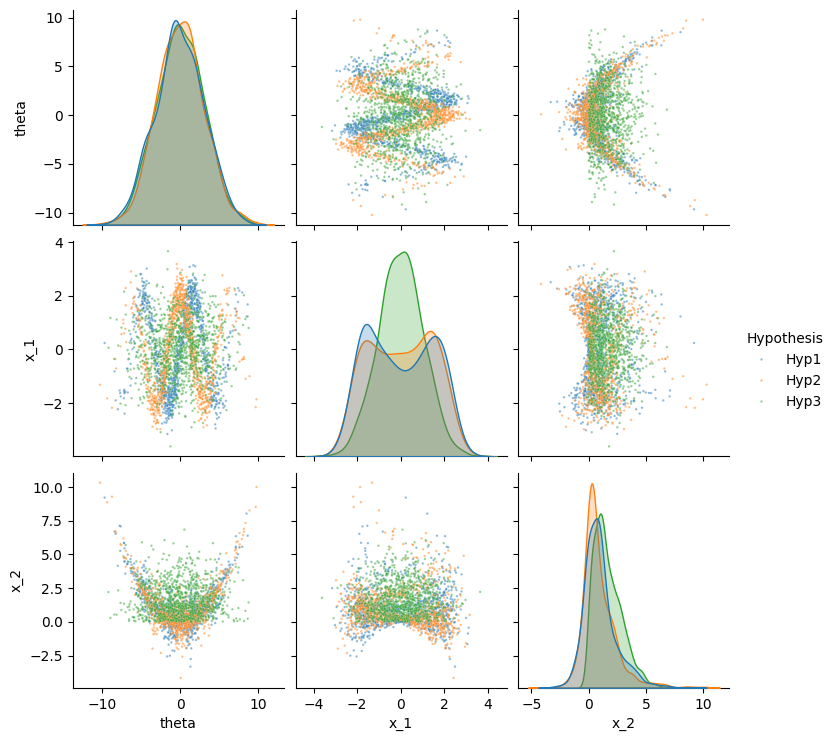

In [5]:
# Plot Hypothesis for visualization

df1 = pd.DataFrame(torch.concatenate([val_theta1, val_x1], dim=1).numpy(), columns=['theta', 'x_1', 'x_2'])
df2 = pd.DataFrame(torch.concatenate([val_theta2, val_x2], dim=1).numpy(), columns=['theta', 'x_1', 'x_2'])
df3 = pd.DataFrame(torch.concatenate([val_theta3, val_x3], dim=1).numpy(), columns=['theta', 'x_1', 'x_2'])

df1["Hypothesis"] = "Hyp1"
df2["Hypothesis"] = "Hyp2"
df3["Hypothesis"] = "Hyp3"

combined_df = pd.concat([df1, df2, df3], axis=0)

plt.figure(figsize=(12,12))
sns.pairplot(combined_df, diag_kind='kde', hue='Hypothesis', plot_kws=dict(alpha=0.5, s=3))
plt.show()

## Setting up the ModelTransfuser

Now we introduce the core of the COMPASS workflow: the `ModelTransfuser` (or `MTf`). <br>
This object will manage all our models, handle the training, and perform the final comparison.

First, we initialize it and tell it where to save its progress.<br>
Then, we use `add_data` to register each of our hypotheses along with their corresponding training and validation datasets.

In [6]:
# Initialize the ModelTransfuser
mtf = MTf(path="data/tutorial_Gaussians")

# Add the training and validation data
mtf.add_data("Hypothesis 1", theta1, x1, val_theta1, val_x1)
mtf.add_data("Hypothesis 2", theta2, x2, val_theta2, val_x2)
mtf.add_data("Hypothesis 3", theta3, x3, val_theta3, val_x3)

Data added to model Hypothesis 1
Data added to model Hypothesis 2
Data added to model Hypothesis 3


Next, we initialize the neural networks for each model. <br>
The `ModelTransfuser` will create a `ScoreBasedInferenceModel` (`SBIm`–our diffusion transformer) for each hypothesis.

We just need to specify the architecture of the models. <br>

- `sde_type`    - Specifies the type of stochastic differential equation (SDE) to use (e.g. "vesde").
- `sigma`       - The noise level for the SDE.
- `hidden_size` - The size of the hidden layers.
- `depth`       - The number of self-attention blocks.
- `num_heads`   - The number of attention heads in the transformer.
- `mlp_ratio`   - The expansion ratio of the feedforward layers to the hidden size.


In [9]:
mtf.init_models(sde_type="vesde", sigma=3, hidden_size=20, depth=4, num_heads=5,  mlp_ratio=4)

Models initialized: ['Hypothesis 1', 'Hypothesis 2', 'Hypothesis 3']


### Training the Models

With everything set up, we can now train our models. <br>
The `train_models` method will automatically train a surrogate network for each hypothesis until they converge. <br>
This is the most computationally intensive step, but it's a one-time "amortized" cost. <br>
Once the models are trained, inference is extremely fast.

`compass` is set up to utilize all available GPUs, if the `device` argument is set to `"cuda"` (default).


In [10]:
mtf.train_models(batch_size=256)

Model Hypothesis 1 trained
Model Hypothesis 2 trained
Model Hypothesis 3 trained


You can also add pretrained models to the `MTf` with the `add_model` method.

In [11]:
# Load the pretrained models

# sbim1 = SBIm.load("data/tutorial_Gaussians/Hypothesis 1.pt", device="cuda")
# sbim2 = SBIm.load("data/tutorial_Gaussians/Hypothesis 2.pt", device="cuda")
# sbim3 = SBIm.load("data/tutorial_Gaussians/Hypothesis 3.pt", device="cuda")

# mtf.add_model("Hypothesis 1", sbim1)
# mtf.add_model("Hypothesis 2", sbim2)
# mtf.add_model("Hypothesis 3", sbim3)

### Performing the Model Comparison

After training/loading the surrogate models, we can perform the model comparison and parameter inference.

First we create a new set of test data from our Hypothesis 1. <br>
These 100 samples are the observations we will use for the model comparison.

The `compare` method takes these observations and computes the posterior probabilities for each hypothesis $P(\mathcal M_i|x_{obs})$ by executing the following automated pipeline:
- **Parameter Estimation**<br>
Inferring the maximum-a-posteriori (MAP) parameters for each model.

- **Likelihood Modelling**<br>
Modelling the likelihood function under the MAP estimate.

- **Likelihood Evaluation**<br>
Evaluating the likelihood of the observations under each hypothesis.

- **Posterior Model Probability**<br>
The models are ranked based on their maximized likelihoods. 
These likelihoods are converted into posterior model probabilities, using the Akaike Information Criterion (AIC), which simplifies to a direct comparison of likelihoods if the models have the same number of parameters.

In [12]:
# Create test data
test_theta1, test_x1 = gen_data_hyp1(100)

# Compare models on test data
mtf.compare(x=test_x1, device="cuda", timesteps=500, method="dpm", order=1)

Probabilities of the models after 100 observations:
Hypothesis 1: 100.00 %
Hypothesis 2:   0.00 %
Hypothesis 3:   0.00 %

Model Hypothesis 1 fits the data best with a relative support of 100.0% among the considered models.


After the analysis of the 100 observations, `compass` is 100% confident, that Hypothesis 1 fits the data best under the 3 considered models.

The results of the comparison are saved in a results dictionary as a pickle file under the earlier specified path.<br>
Under the name of the model, the dictionary contains the:
- `MAP`: The maximum a posteriori estimate of the model parameters.
- `log_probs`: The log probabilities of the observations under the model.
- `obs_probs`: The probabilities of the observations under the model.
- `AIC`: The Akaike Information Criterion, a measure of the relative quality of the model.
- `model_probs`: The probabilities of each model given the data.
- `attn_weights`: The attention weights learned by the model.

## Visualization of Results
`compass` provides easy-to-use plotting functions to visualize the results of the model comparison.

The `plot_comparison` method generates two plots:
- **Violin Plot** <br>
This shows the distribution of posterior probabilities for each model based on single observations.
We can see that for most individual data points, Hypothesis 1 (orange) is already strongly preferred.

- **Cumulative Posterior Probability Plot** <br>
This plot displays the cumulative posterior probabilities for each model as more data is observed.
The confidence in Hypothesis 1 (orange) grows with more data, while the confidence in the other hypotheses diminishes.

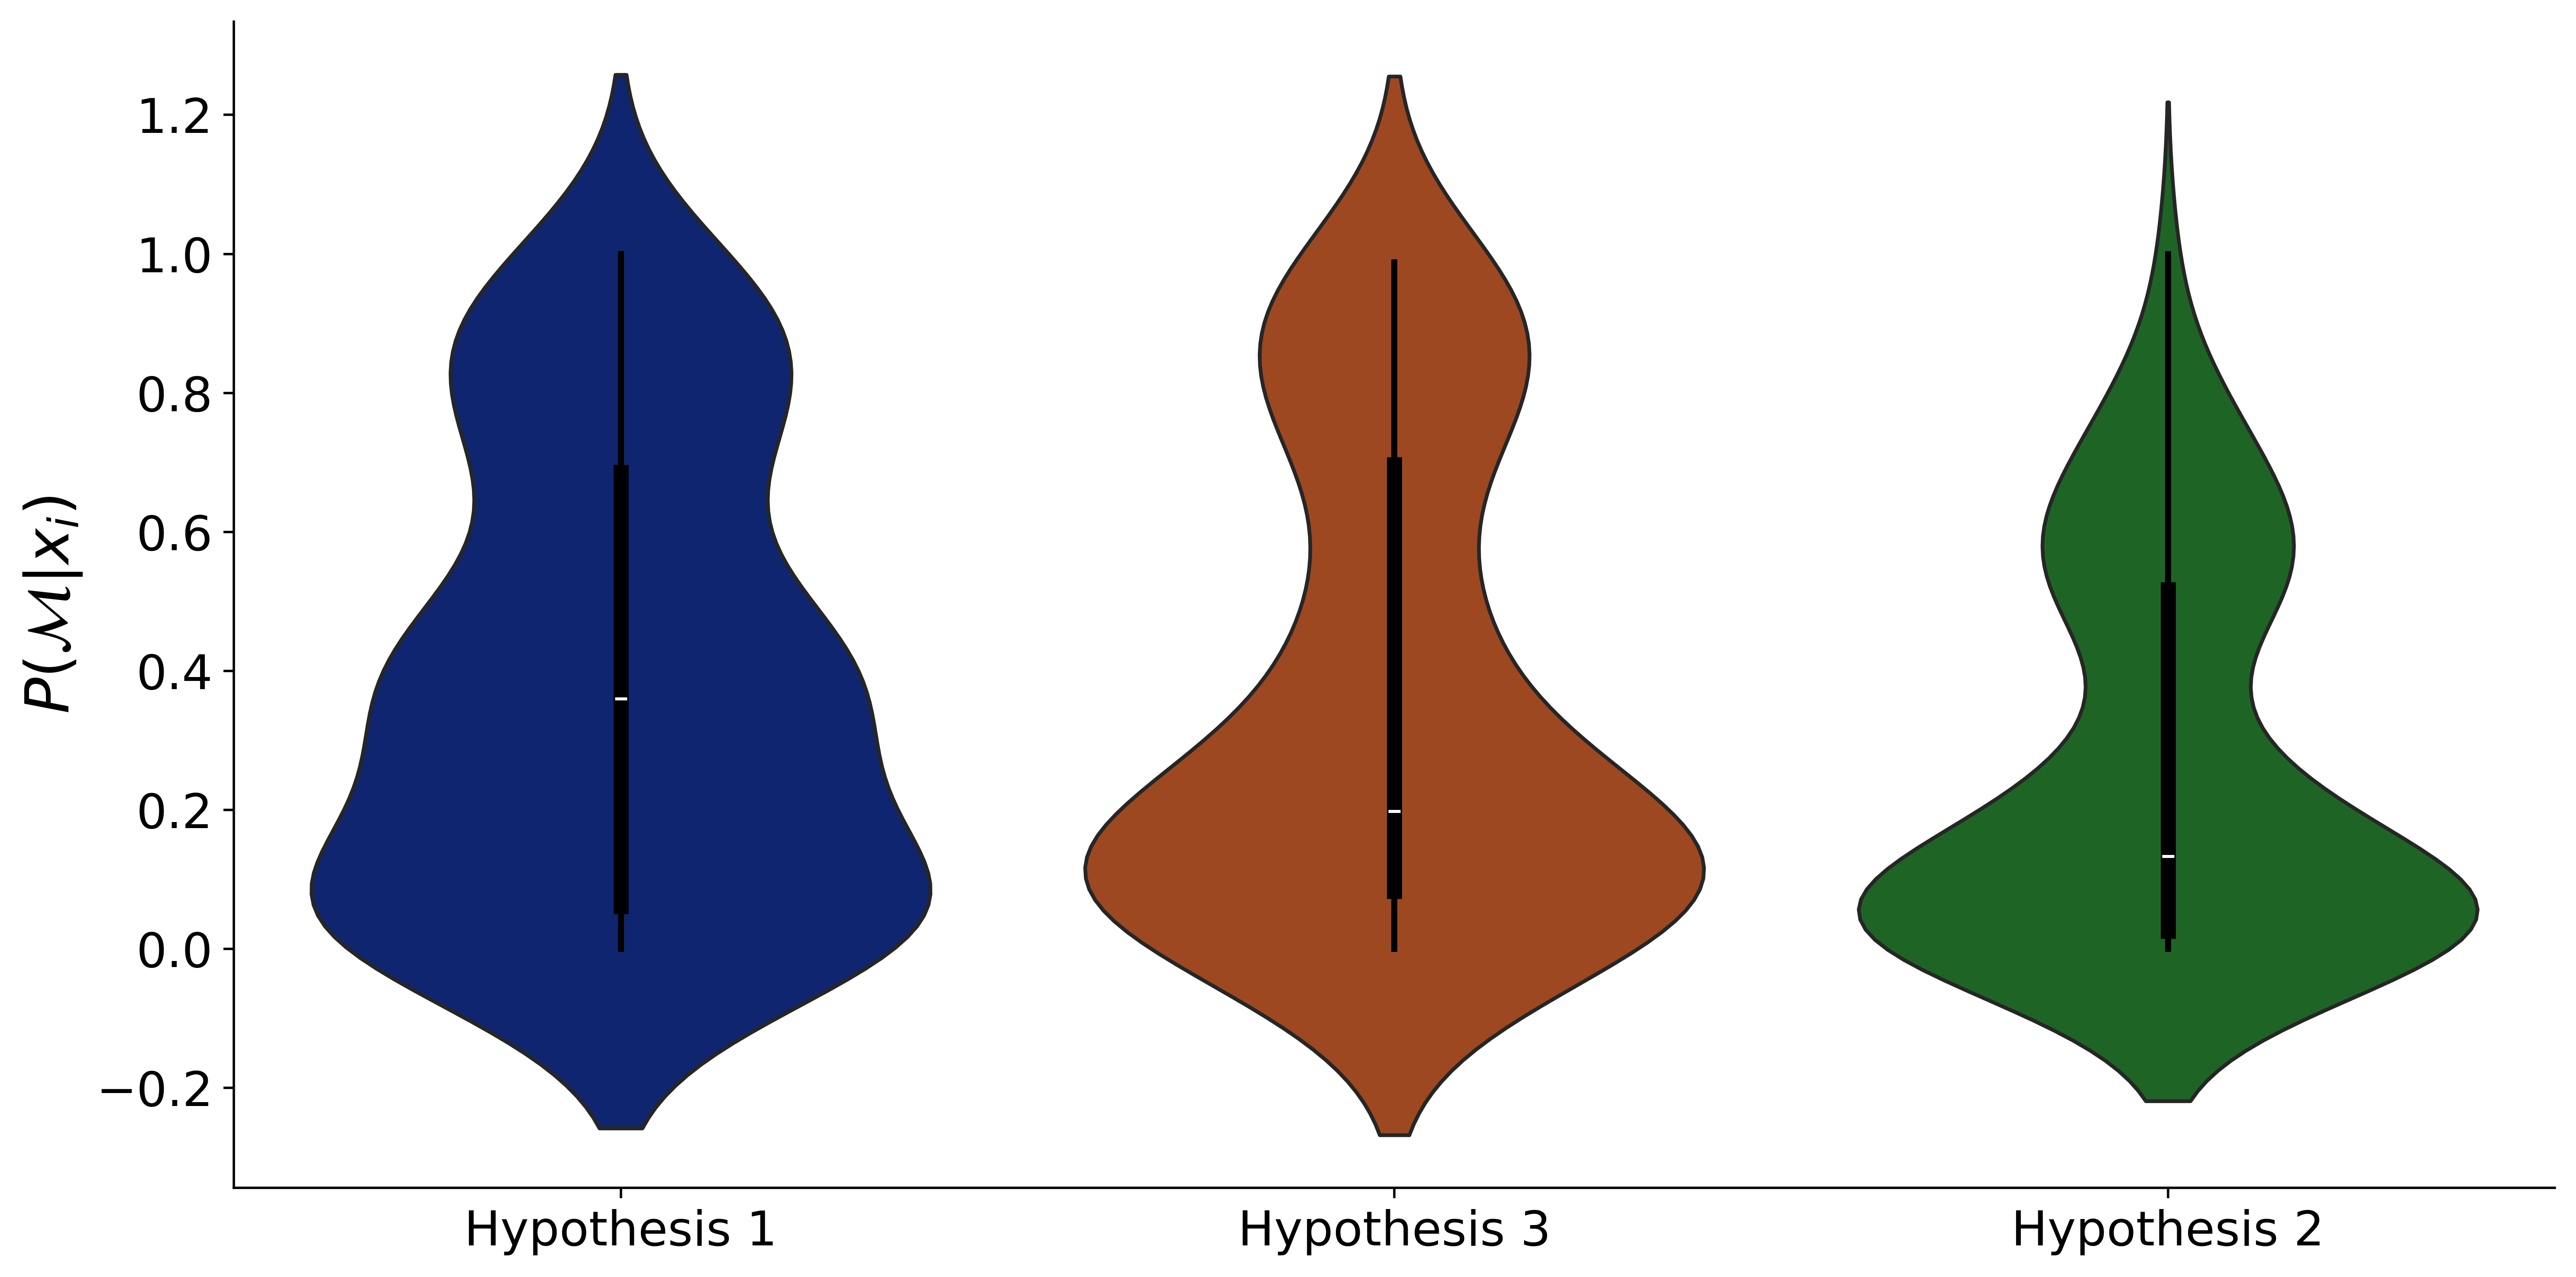

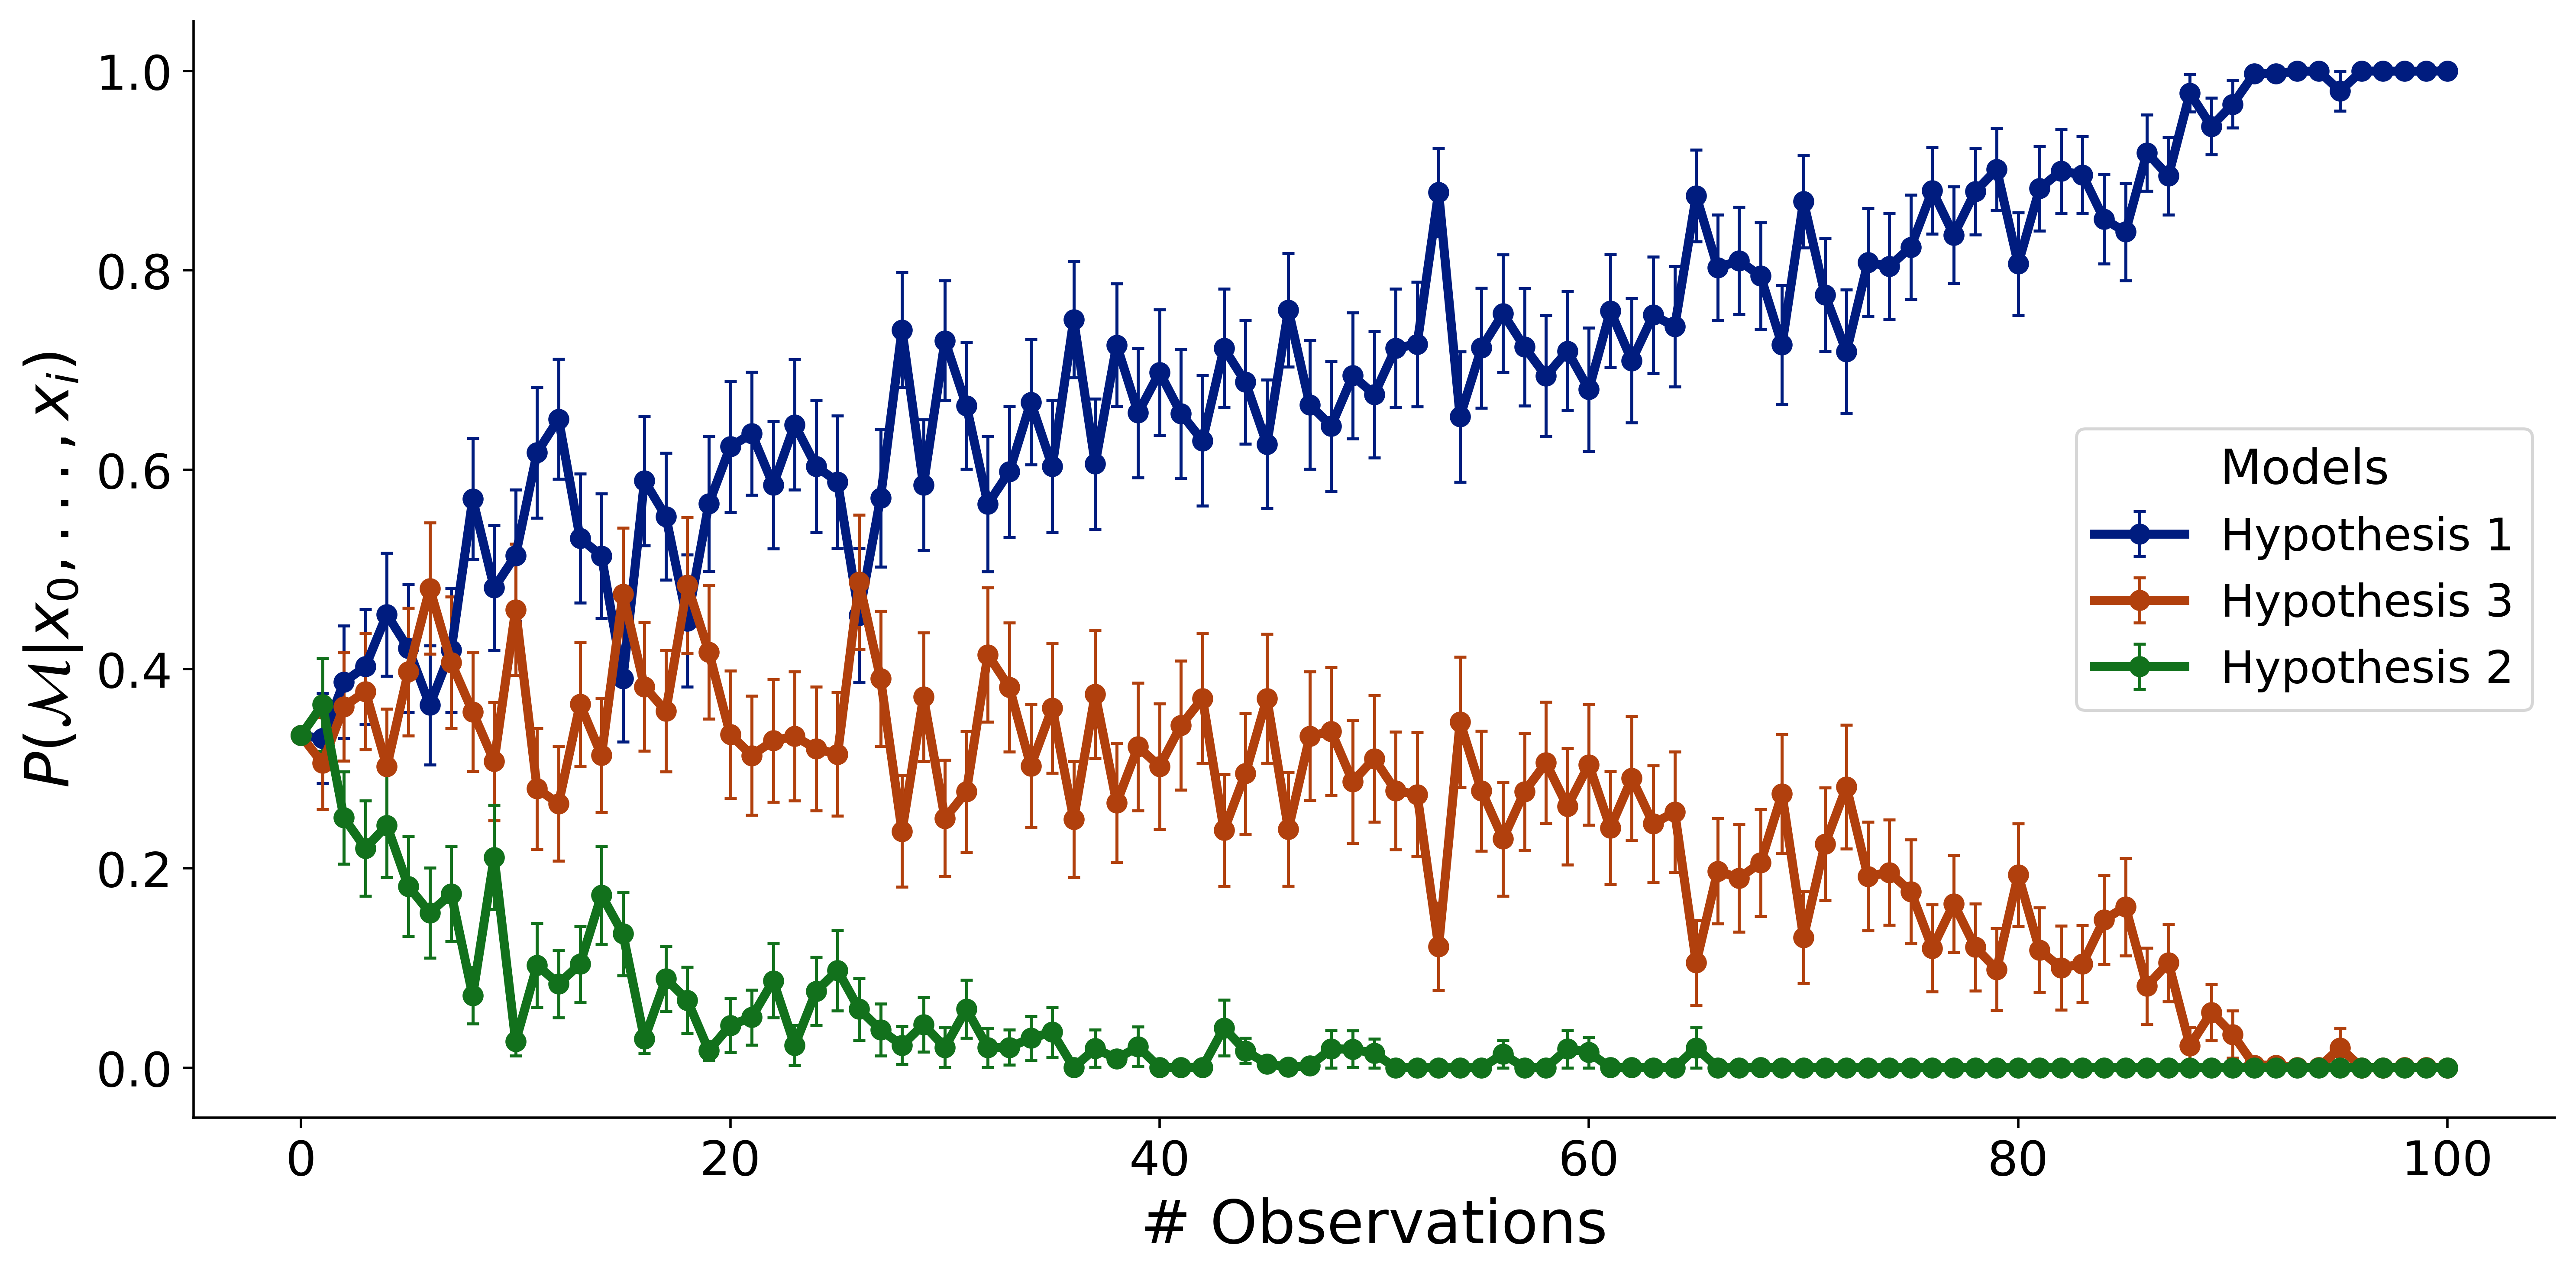

In [ ]:
mtf.plot_comparison()

####  Interpreting the "Black Box" with Attention Maps
A key feature of `compass` is its interpretability.
Since it's based on a transformer, we can inspect the internal self-attention mechanism to understand how the model is making its decisions. <br>
The rows (Queries) represent the parameter/variable whose value is being inferred, while the columns (Keys) represent the sources of information the model can "look at". <br>
The bias KV term is a learned bias that adjusts the Key and Value information flow and acts like a "memory" or an effective prior, capturing the overall structure of the problem.

The `plot_attention` method visualizes the attention weights for the best performing model (Hypothesis 1) with two plots:
- **Average Attention Map** <br>
This heatmap shows the attention weights for each parameter/variable combination in the model averaged over all heads and layers.
Lighter colors indicate higher attention weights.

- **Layer-by-Layer Attention Maps** <br>
These maps show the attention weights for each layer in the model, allowing us to see how the model's focus changes as it processes the input.


**Interpretation**<br>
The attention maps provide a powerful window into the model's internal reasoning, allowing us to move beyond simply getting an answer and start understanding how the model arrived at its conclusion. 
This is a crucial step for building trust and ensuring the model's logic aligns with our scientific understanding.

The maps show where the model "looks" when it needs to infer a particular variable. High attention weights indicate a strong flow of information.<br>
In a well-trained model, we expect the attention patterns to reflect the known causal structure of the simulator.
For example, if a parameter $\theta$ directly influences an observation $x$, we would expect to see high attention from the $\theta$ query to the $x$ key. <br>
The "Bias KV" term represents the model's learned internal state or "memory." High attention to this term suggests the model is relying on a strong, data-driven prior or has learned a general representation of the problem's structure that doesn't depend on any single input.



In our toy problem, the attention maps for the best performing model (Hypothesis 1) confirm its logic is sound. When inferring the parameter $\theta$, the model correctly focuses its attention on the observations $x_1$ and $x_2$, which directly depend on it. This confirms that the model has successfully learned the fundamental relationships defined in our simulator. <br>
The Layer-by-Layer view further reveals a hierarchical reasoning process, where the model's focus can shift as it processes information from lower to higher levels of abstraction.

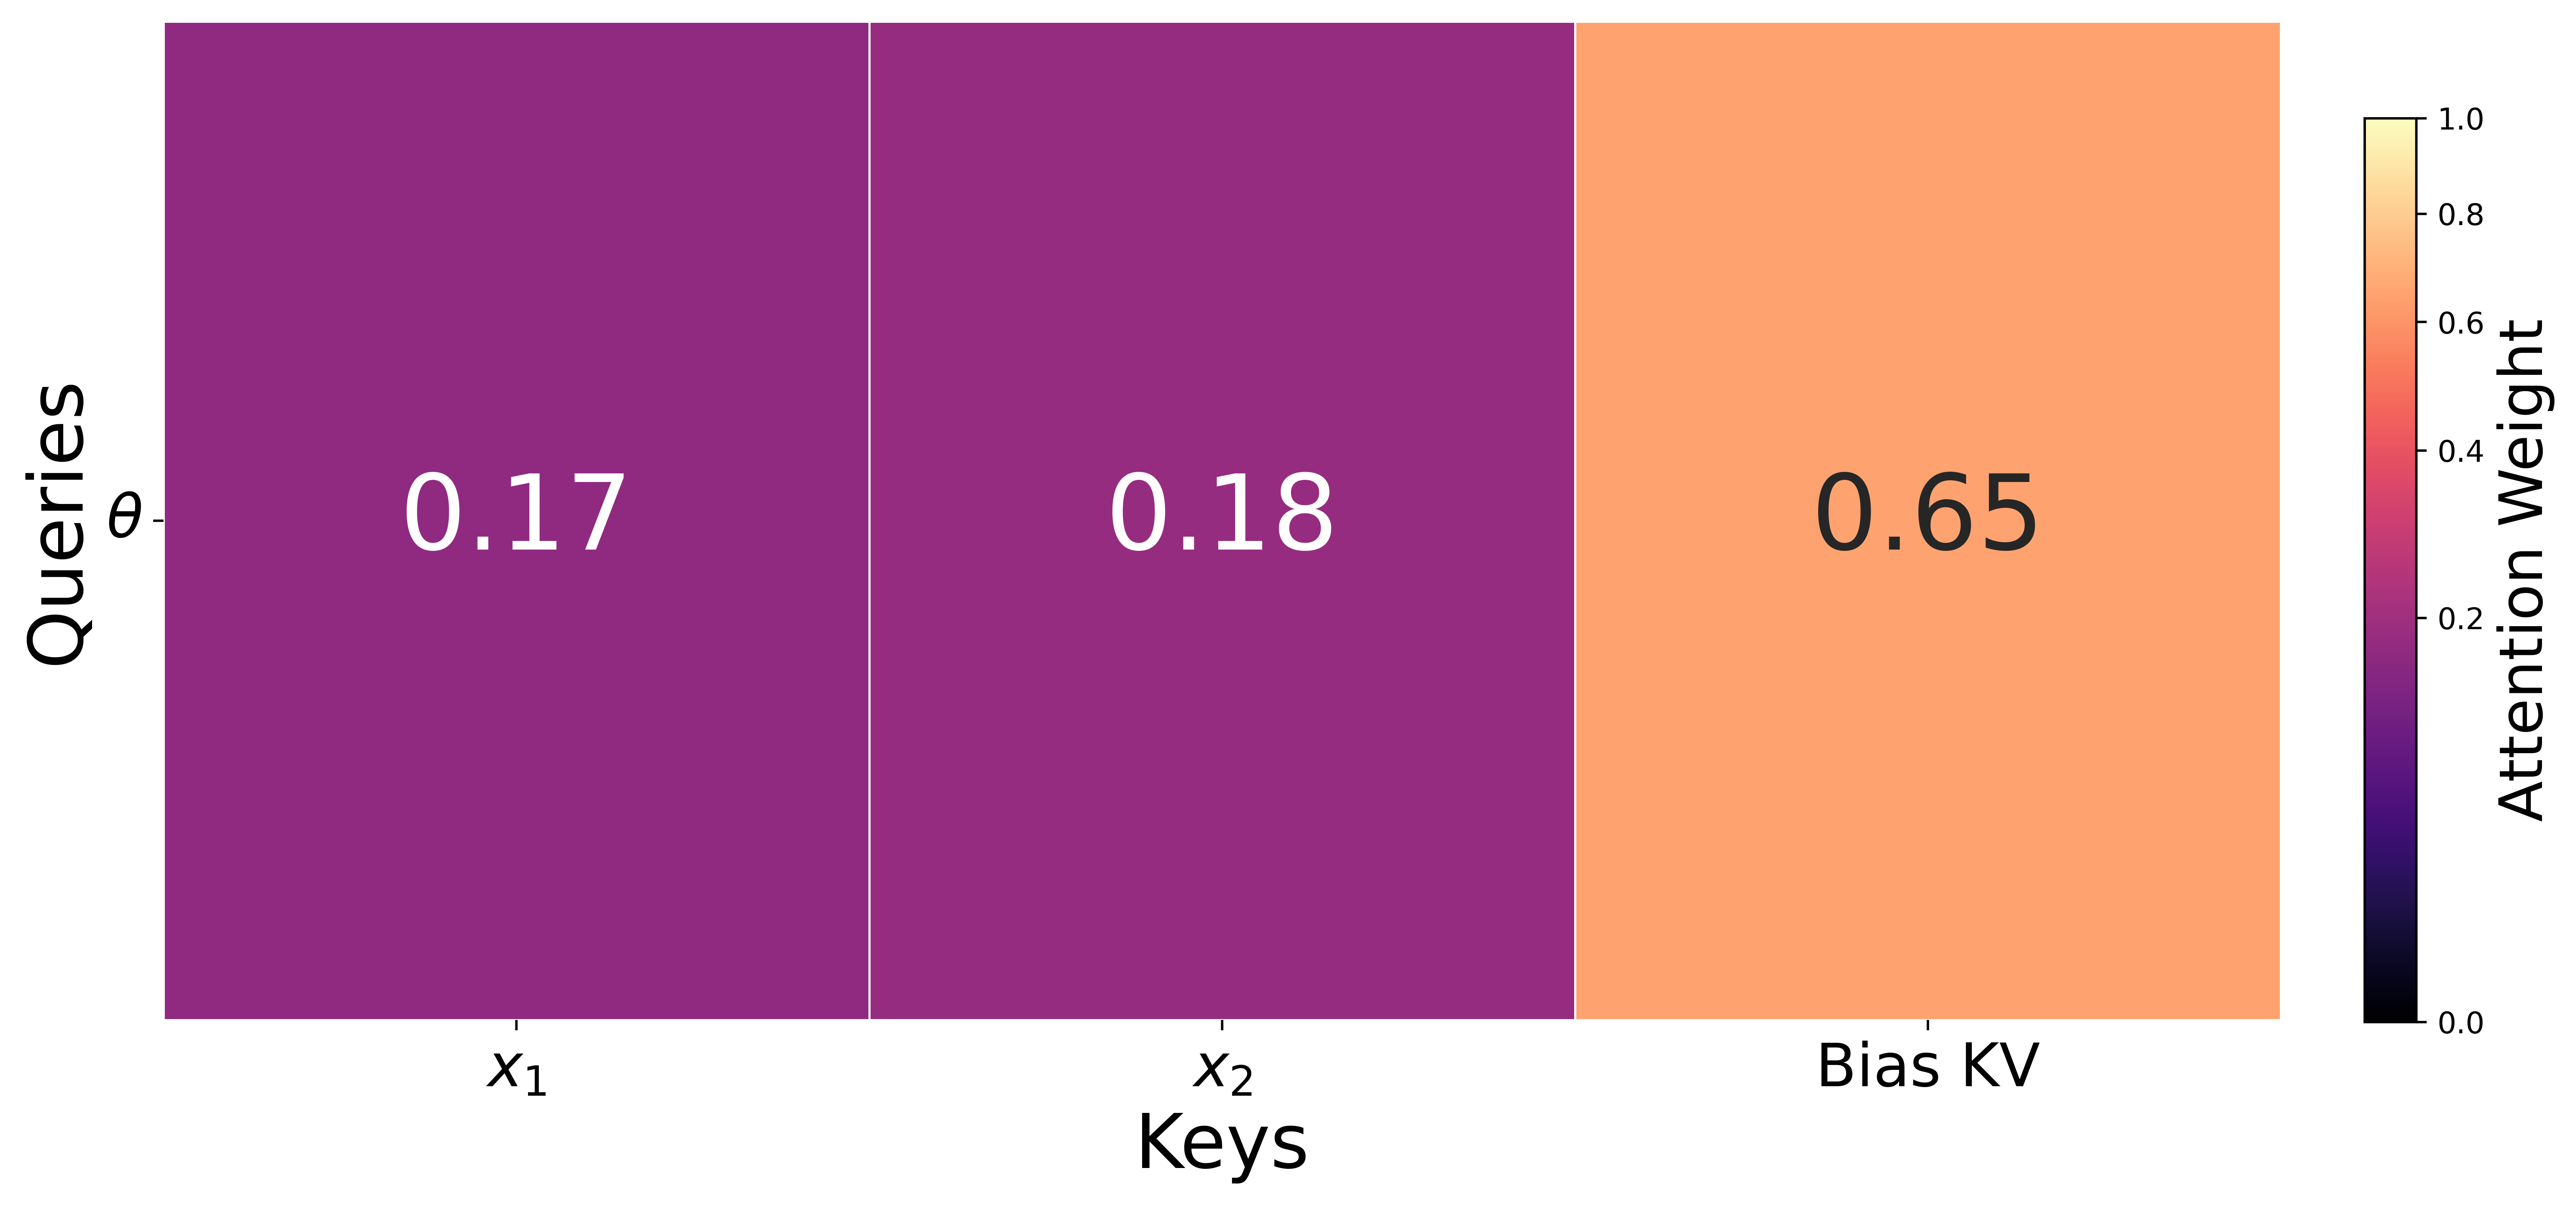

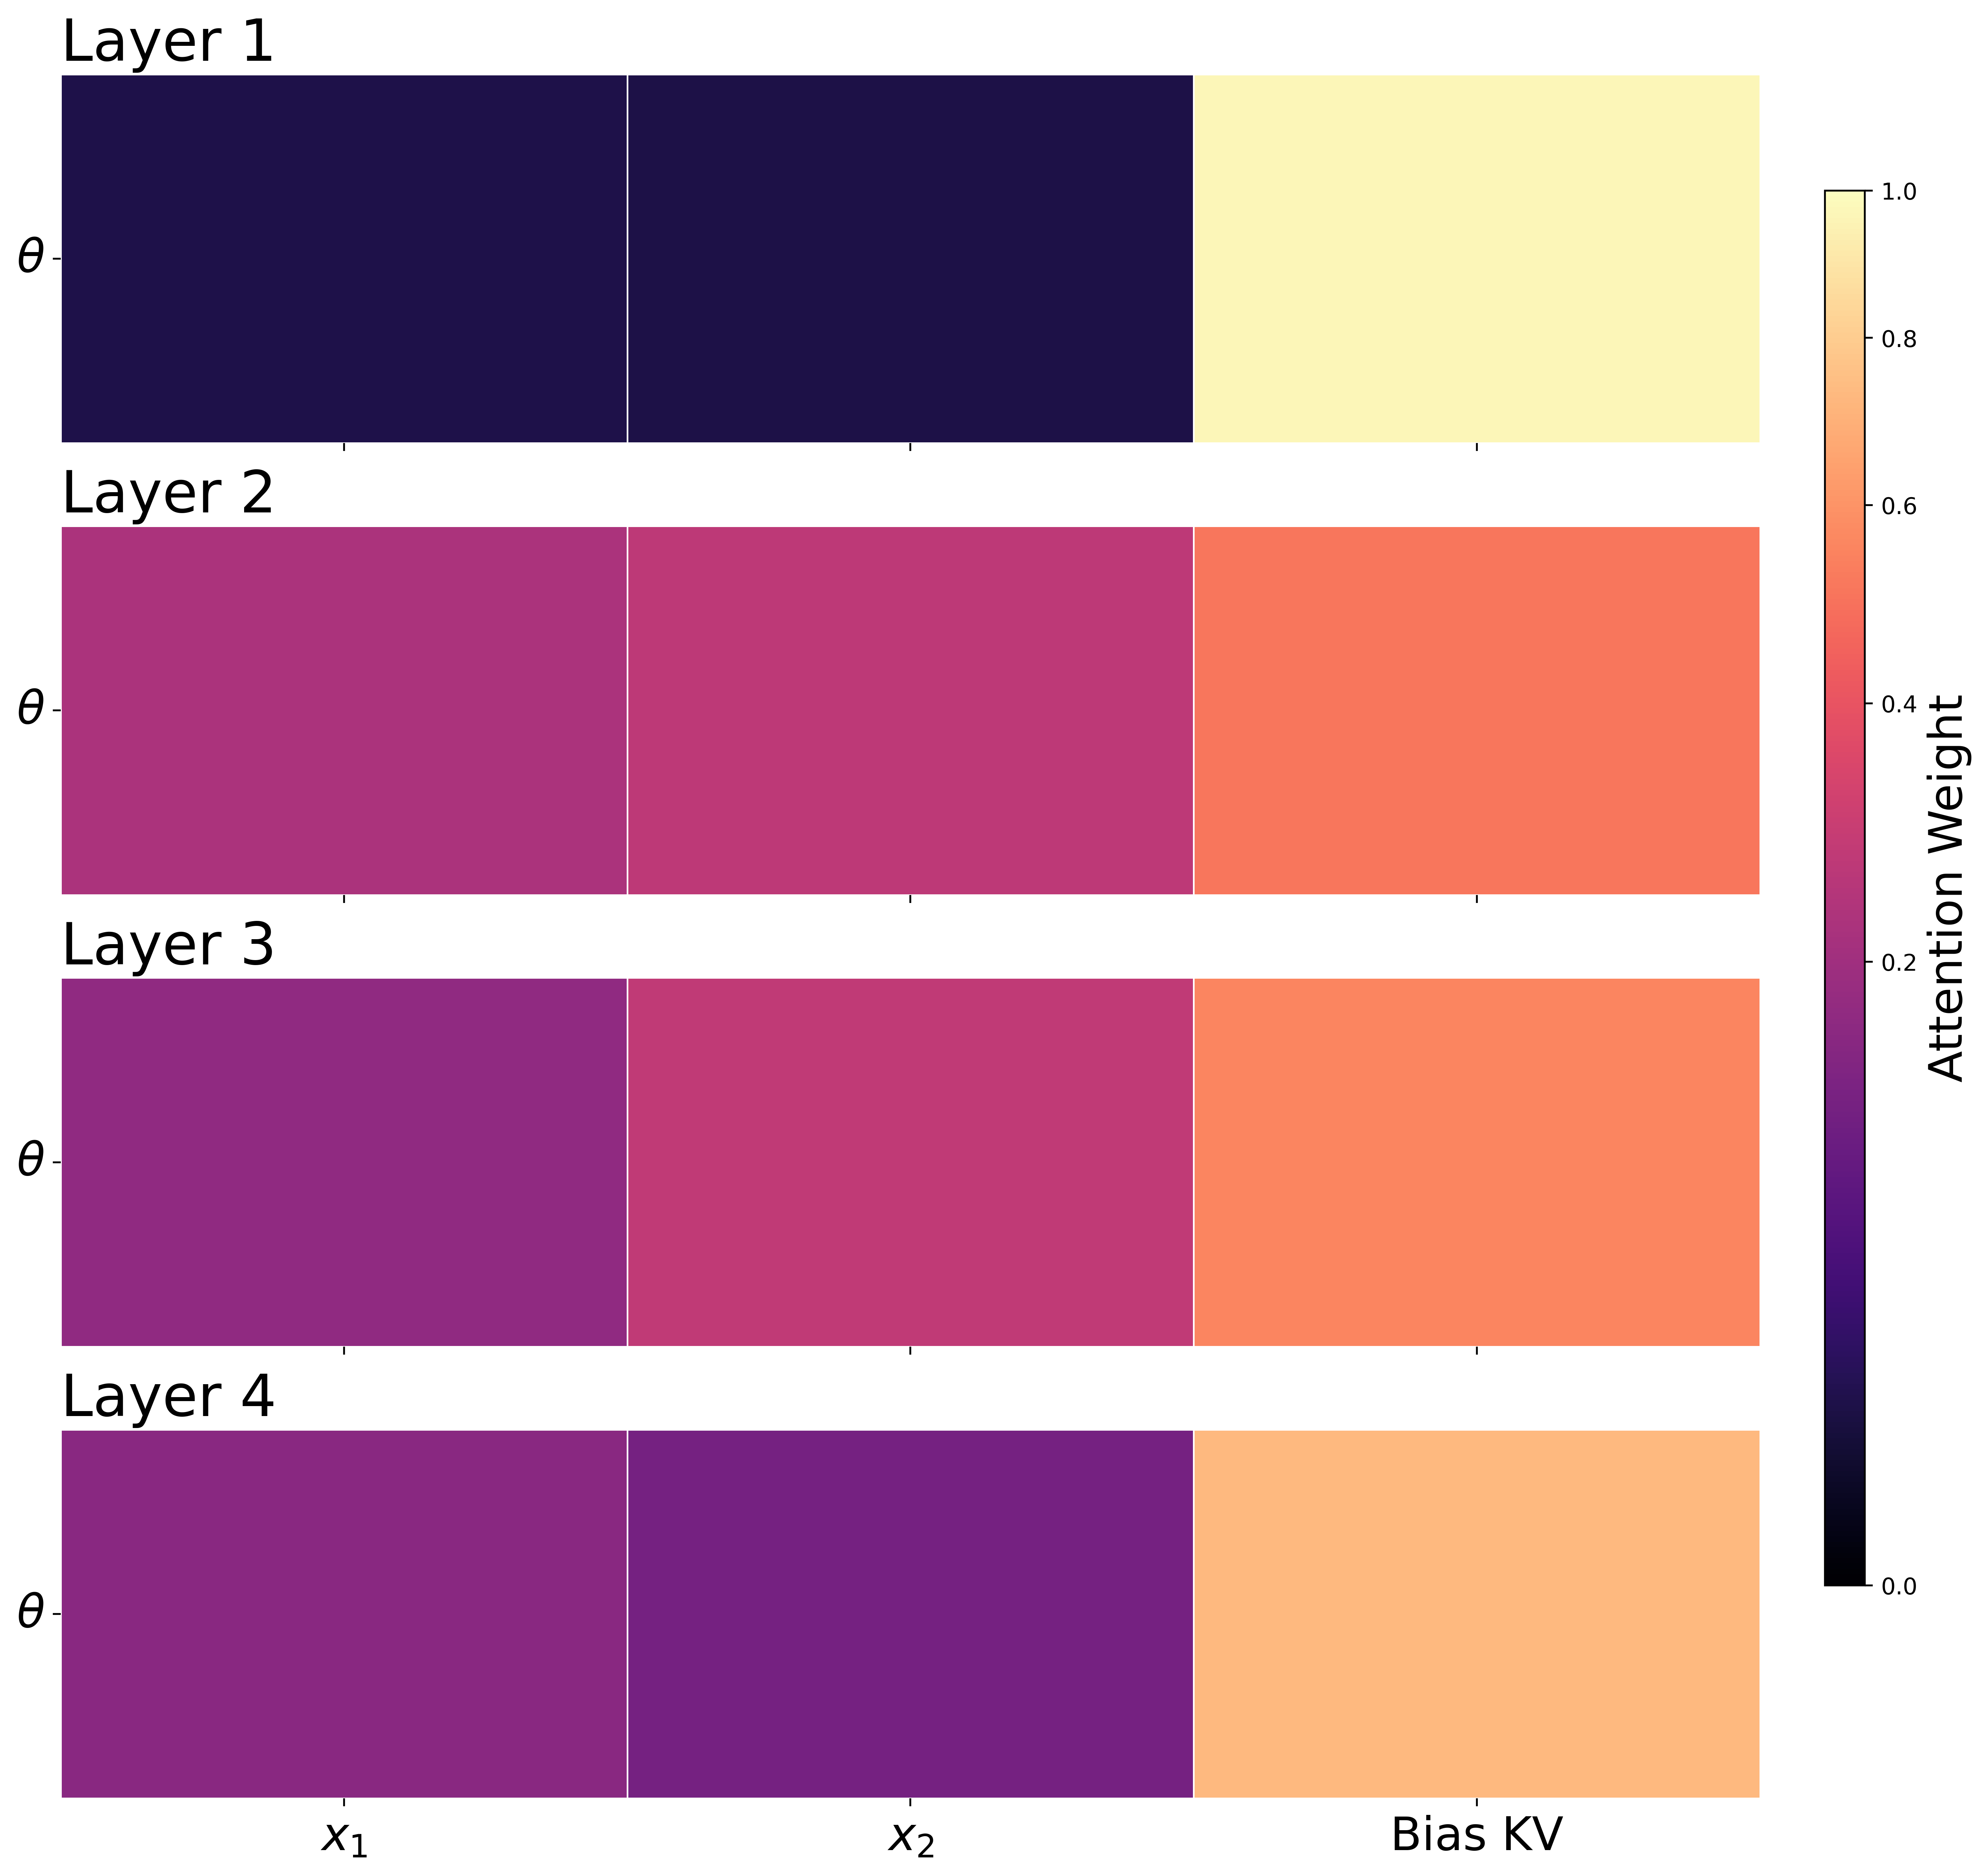

In [ ]:
mtf.plot_attention(labels=[r"$\theta$", r"$x_1$", r"$x_2$"])